In [4]:
pip install tensorflow

In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
import pickle
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import InputLayer, LSTM, Concatenate, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

In [6]:
# Loading preprocessed data
train_df = pd.read_csv("/content/train_news.csv")
test_df = pd.read_csv("/content/test_news.csv")

In [7]:
# Initializing tokenizer
tokenizer = Tokenizer(num_words=8000)
tokenizer.fit_on_texts(train_df["content"])

# Saving the tokenizer
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

# Converting text to sequences
X_train_seq = tokenizer.texts_to_sequences(train_df["content"])
X_test_seq = tokenizer.texts_to_sequences(test_df["content"])

In [8]:
# Optimal length for covering 95% of sequences
optimal_len = int(np.percentile([len(seq) for seq in X_train_seq], 95))

# Padding sequences to make the length uniform
X_train_pad = pad_sequences(X_train_seq, maxlen=optimal_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=optimal_len, padding='post', truncating='post')

# Preparing target labels
y_train = train_df["label"].values
y_test = test_df["label"].values

In [9]:
print(f"Training shape: {X_train_pad.shape}, Test shape: {X_test_pad.shape}")
print(f"Sample padded sequence:\n{X_train_pad[1]}")

Training shape: (62172, 414), Test shape: (15544, 414)
Sample padded sequence:
[   1  371   99   33 4643  136 7135  139    4 5564 1711 3002 4909   43
   17  371  663  395    6   18    1  140  151  635  334 1354   75    4
  100 1859   75 1244  862  137   10  156   16  240  138 1012  526  434
   87 1522   99  371   99 1313  805   12 4643  296 3539    4  100  784
  603  177 7887 3531  100  177 1378 2898    3 1275   16  240    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    

In [10]:
# Checking the amount of sequences truncated (loss of information)
n_truncated = sum(len(seq) > optimal_len for seq in X_train_seq)
print(f"Percentage of total sequences truncated: {round(n_truncated/len(X_train_seq)*100, 2)}%")

Percentage of total sequences truncated: 5.0%


In [11]:
# LSTM Model Architecture
model = Sequential([
    # Input Layer
    InputLayer(input_shape=(optimal_len,)),

    # Embedding layer
    Embedding(input_dim=8000, output_dim=128, mask_zero=True), #Converts words into dense vectors,captures semantic relationships

    # 1st hidden Layer
    LSTM(64, dropout=0.2, return_sequences=True), #Captures contextual meaning and long-range dependencies"

    # 2nd hidden layer
    LSTM(32, dropout=0.2, return_sequences=True),

    # 3rd hidden layer
    LSTM(16, dropout=0.2),

    # 4th hidden layer
    Dense(8, activation='relu'), #Adds non-linearity, extracting higher-level patterns

    # Output layer
    Dense(1, activation='sigmoid') #Binary classification
])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 414, 128)            │       1,024,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 414, 64)             │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 414, 32)             │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 16)                  │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,089,105 (4.15 MB)

 Trainable params: 1,089,105 (4.15 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Compiling the model
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy', 'precision', 'recall'])

# Training the model
history = model.fit(
    X_train_pad, y_train,
    epochs=5,
    batch_size=64
)
print("Model Training Completed")

Epoch 1/5
972/972 ━━━━━━━━━━━━━━━━━━━━ 1120s 1s/step - accuracy: 0.8245 - loss: 0.4023 - precision: 0.8440 - recall: 0.8174
Epoch 2/5
972/972 ━━━━━━━━━━━━━━━━━━━━ 1163s 1s/step - accuracy: 0.9321 - loss: 0.1678 - precision: 0.9515 - recall: 0.9106
Epoch 3/5
972/972 ━━━━━━━━━━━━━━━━━━━━ 1160s 1s/step - accuracy: 0.9367 - loss: 0.1608 - precision: 0.9589 - recall: 0.9131
Epoch 4/5
972/972 ━━━━━━━━━━━━━━━━━━━━ 1165s 1s/step - accuracy: 0.9544 - loss: 0.1128 - precision: 0.9706 - recall: 0.9374
Epoch 5/5
972/972 ━━━━━━━━━━━━━━━━━━━━ 1112s 1s/step - accuracy: 0.9620 - loss: 0.0894 - precision: 0.9762 - recall: 0.9472
Model Training Completed


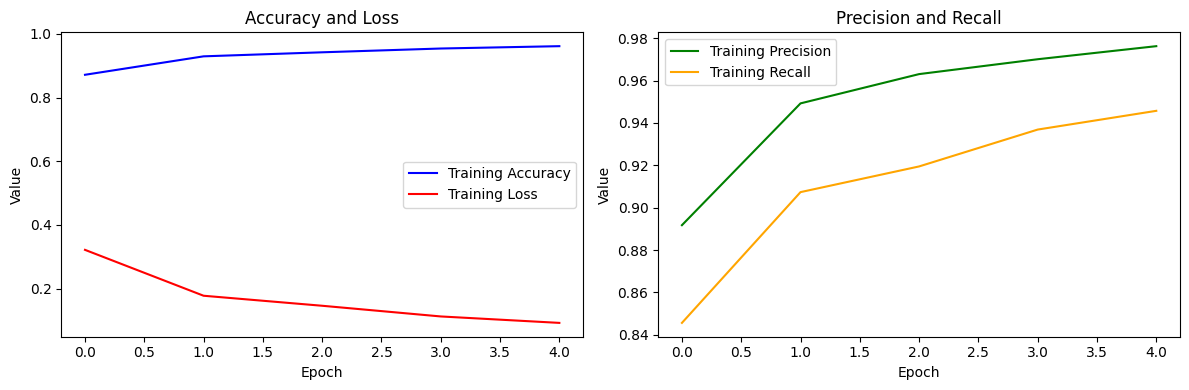

In [13]:
# Plotting accuracy and loss
plt.figure(figsize=(12, 4))

# Plot accuracy and loss
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['loss'], label='Training Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Accuracy and Loss')
plt.legend()

# Plot precision and recall
plt.subplot(1, 2, 2)
plt.plot(history.history['precision'], label='Training Precision', color='green')
plt.plot(history.history['recall'], label='Training Recall', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Precision and Recall')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
# Evaluating on the test set
loss, accuracy, precision, recall = model.evaluate(X_test_pad, y_test)

# Calcualting f1-score
if precision + recall == 0:
    f1_score = 0.0
else:
    f1_score = 2 * (precision * recall) / (precision + recall)

486/486 ━━━━━━━━━━━━━━━━━━━━ 77s 155ms/step - accuracy: 0.9443 - loss: 0.1437 - precision: 0.9630 - recall: 0.9223


In [15]:
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

Test Loss: 0.1420
Test Accuracy: 0.9454
Test Precision: 0.9639
Test Recall: 0.9254
F1 Score: 0.9443


In [16]:
model.save('Fake_News_Detector_Model.keras')
print("Model saved as Fake_News_Detector_Model.keras")

Model saved as Fake_News_Detector_Model.keras
